EE488 Exercise #3: Variational Autoencoders(VAE)
====
TA : JongSuk Kim

TA's E-mail : jskpop@kaist.ac.kr
## Instruction
- In this practice, we will generate data from VAEs with MNIST Dataset
- Understand reconstruction loss and kld loss mathematically and implement them in code.
- Also, we will use two types of backbone network for training VAE. The first is based on FC layer, and second is implemented with convolution neural network and transposed convolution neural network.

## Questions
- Please use QnA board in KLMS and **Classum**. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Exercise 3]" in the subject for all questions regarding this practice


In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T 
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils import data
import matplotlib.pyplot as plt


### Initilaize Data Loader

In [ ]:
root='./data'
batch_size=32
# Use Mnist data for training

mnist_train = vision_dsets.MNIST(root = root,  
                                train = True,  
                                transform = T.ToTensor(),
                                download = True) 

# Use only 0 and 1 image
idx = (mnist_train.targets==0) | (mnist_train.targets==1)
mnist_train.targets = mnist_train.targets[idx]
mnist_train.data = mnist_train.data[idx]

mnist_test = vision_dsets.MNIST(root = root,
                                train = False, 
                                transform = T.ToTensor(),
                                download = True)

# Use only 0 and 1 image
idx = (mnist_test.targets==0) | (mnist_test.targets==1)
mnist_test.targets = mnist_test.targets[idx]
mnist_test.data = mnist_test.data[idx]

trainDataLoader = data.DataLoader(dataset = mnist_train,  
                                    batch_size = batch_size, 
                                    shuffle =True, 
                                    num_workers = 1) 

testDataLoader = data.DataLoader(dataset = mnist_test, 
                                batch_size = batch_size,
                                shuffle = False, 
                                num_workers = 1) 


### **Define Neural Network for VAE training(FC layer)**

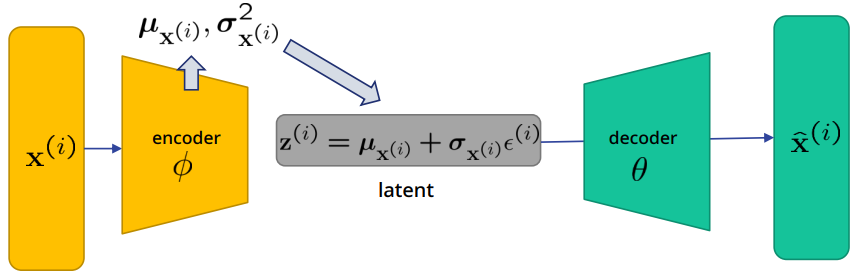

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)

        # predict mu
        self.fc31 = nn.Linear(h_dim2, z_dim)
        
        # predict log_var
        self.fc32 = nn.Linear(h_dim2, z_dim)
        
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

        
    def encoder(self, x):
        # Encoder predict mu and log_var 
        x = x.view(-1,784)

        # first hidden layer
        h = F.relu(self.fc1(x))

        # second hiddden layer
        h = F.relu(self.fc2(h))

        # predict mean and variance
        mu = self.fc31(h)
        log_var = self.fc32(h)

        return mu, log_var
    
    def sampling(self, mu, log_var):
        #reparameterization
        #compute standard eviation
        std = torch.exp(0.5*log_var)

        # make random value in gaussian distribution eps
        eps = torch.randn_like(std)

        #compute z
        z = eps.mul(std).add_(mu)

        return z 
        
    def decoder(self, z):
        # reconstruct image with latent z
        # first hidden layer
        h = F.relu(self.fc4(z))
        
        # second hidden layer
        h = F.relu(self.fc5(h))

        # make output
        h = torch.sigmoid(self.fc6(h))

        return h 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var #self.decoder(z) for mse value,(mu, log_var) for kld loss

### **VAE with Reconstruction loss and Regularization loss(KLD loss)**

$$ \mathcal{L}\left(\theta, \phi ; \mathbf{x}^{(i)}\right)= - \underbrace{\mathbb{E}_{q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x}^{(i)} \mid \mathbf{z}\right)\right]}_\text{Reconstruction loss} \underbrace{ +{\lambda}D_{K L}\left(q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right) \| p_{\boldsymbol{\theta}}(\mathbf{z})\right)}_\text{Regularization loss} $$

- The reconstruction loss pursue the decoder's mean output closer to the data x. It can be computed as below
    - Input: $x_i$
    - Decoder output: $\hat x_i$  
    - $MSE loss = ||x_i-\hat x_i||^2$
- Add regularization loss(KL divergence) to make distribution should be similar to a zero-mean unit-variance Gaussian along all dimensions. 
- As explained in the lecture note, KLD loss can be computed as follows:
- The regularization loss in the upper equation ($D_{K L}\left(q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right) \| p_{\boldsymbol{\theta}}(\mathbf{z})\right)$)  can be computed as below.
    - As mentioned above, the regularization loss tries to reduce difference between $ q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right) $ and $  p_{\boldsymbol{\theta}}(\mathbf{z}) $.
    - $ q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right)$ ~ $ \mathcal{N}(\mu_{x}, \sigma_{x})$
    - $ p_{\boldsymbol{\theta}}(\mathbf{z}) $ ~ $ \mathcal{N}(0, \mathbf{I})$
    - $\mu_x, \sigma_x, \mathbf{I}$ have dimension size of $N$.
    - $KLD = \sum_{j=1}^{N} KL{(N(\mu_j, \sigma_j), N(0,1))}\ =  -{1 \over 2} \sum_{j=1}^{N} (1 + log(\sigma_j^2) -\mu_j^2 - \sigma_j^2)$
    - $N$: dimension of latent space (z)
    - variable log_var: $log(\sigma^2)$


### **Define VAE Trainer**

In [ ]:
class VAETrainer():
    def __init__(self, trainloader, testloader, net, optimizer):

        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer

    def mse_kldloss(self, recon_x, x, mu, log_var, lamb=1):
        # compute mse loss
        mseloss = F.mse_loss(recon_x.view(-1,1,28,28), x, reduction='sum')

        # compute kld loss
        kldloss = -0.5*torch.sum(1+ log_var - mu.pow(2) - log_var.exp())

        return mseloss + lamb * kldloss
        
    def train(self, epoch = 1, test_on_train=False):
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, (inputs, _) in enumerate(self.trainloader, 0): 
                inputs = inputs.cuda()
                self.optimizer.zero_grad()    

                # forward
                recon, mu, log_var = self.net(inputs)

                # compute loss
                loss = self.mse_kldloss(recon, inputs, mu, log_var)

                loss.backward() 
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if (i+1) % 100 == 0:   
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / (100*len(inputs))))
                    running_loss = 0.0
            if test_on_train:
                self.test()
        print('Finished Training')
        
    def test(self):
        self.net.eval() 

        test_loss = 0
        with torch.no_grad():
            for inputs, _ in self.testloader:
                inputs = inputs.cuda()
                # forward
                recon, mu, log_var = self.net(inputs)

                # compute loss
                loss = self.mse_kldloss(recon, inputs, mu, log_var)

                test_loss += loss.item()

            test_loss /= len(self.testloader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
z_dim = 64
vae_net = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=z_dim)
vae_net.cuda()
optimizer = optim.Adam(vae_net.parameters(), lr=1e-4)

In [ ]:
trainer = VAETrainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = vae_net,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 10, test_on_train=True)

[1,   100] loss: 105.094
[1,   200] loss: 50.058
[1,   300] loss: 45.368
====> Test set loss: 38.3111
[2,   100] loss: 38.183
[2,   200] loss: 38.161
[2,   300] loss: 38.093
====> Test set loss: 37.6011
[3,   100] loss: 38.045
[3,   200] loss: 37.586
[3,   300] loss: 37.712
====> Test set loss: 37.0615
[4,   100] loss: 37.370
[4,   200] loss: 36.534
[4,   300] loss: 35.261
====> Test set loss: 33.8841
[5,   100] loss: 33.900
[5,   200] loss: 33.364
[5,   300] loss: 32.281
====> Test set loss: 32.0435
[6,   100] loss: 31.944
[6,   200] loss: 31.792
[6,   300] loss: 31.652
====> Test set loss: 30.7284
[7,   100] loss: 30.846
[7,   200] loss: 30.846
[7,   300] loss: 30.156
====> Test set loss: 29.8573
[8,   100] loss: 29.699
[8,   200] loss: 29.964
[8,   300] loss: 29.562
====> Test set loss: 28.9733
[9,   100] loss: 28.822
[9,   200] loss: 29.077
[9,   300] loss: 29.191
====> Test set loss: 28.5333
[10,   100] loss: 28.974
[10,   200] loss: 28.505
[10,   300] loss: 28.204
====> Test set 

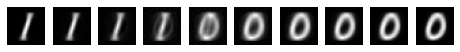

In [ ]:
zero_image = mnist_test.data[mnist_test.targets==0].data.view(-1,1,28,28).cuda()
zero_image = zero_image/255.0
one_image = mnist_test.data[mnist_test.targets==1].data.view(-1,1,28,28).cuda()
one_image = one_image/255.0

zero_z_mu, zero_z_var = vae_net.encoder(zero_image)
one_z_mu, one_z_var = vae_net.encoder(one_image)

z = torch.empty(10,z_dim).cuda()
alpha = torch.linspace(0,1,10)
for i in range(10):
    z[i] = alpha[i]*zero_z_mu[0] + (1-alpha[i])*one_z_mu[0]

# make sample with z
sample = vae_net.decoder(z).cuda()
imgs = sample.view(-1,28,28)
imgs = imgs.detach().cpu()

fig, axes = plt.subplots(1,10,figsize=(8,8))
ax = axes.ravel()
for i in range(10):
    img = imgs[i]
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
plt.show()

### Define Neural Network for VAE training(CNN & Transposed CNN)

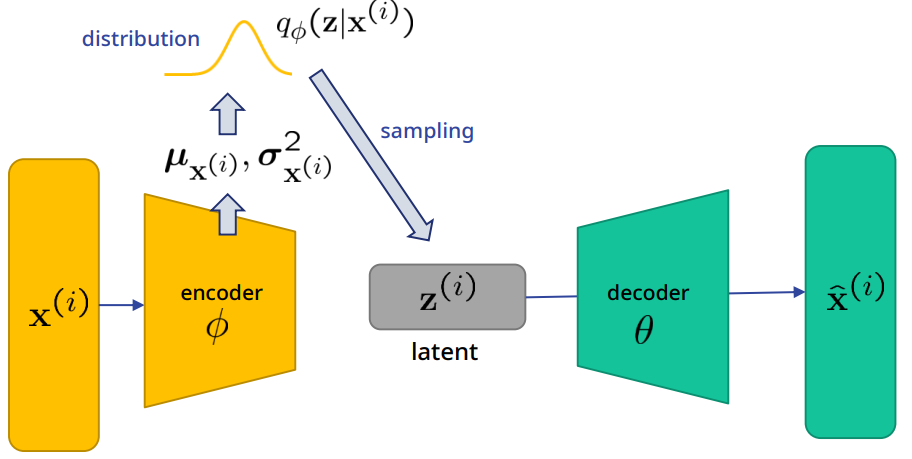

In [ ]:
class VAE(nn.Module):
    def __init__(self, z_dim=256):
        super(VAE, self).__init__()
        #TODO
        # encoder part
        self.encconv1 =  nn.Conv2d(1, 16, 5)
        self.encconv2 = nn.Conv2d(16, 32, 5)

        # predict mu
        self.encfc1 = nn.Linear(32*20*20, z_dim)

        # predict log_var
        self.encfc2 = nn.Linear(32*20*20, z_dim)

        #decoder part
        self.decfc = nn.Linear(z_dim, 32*20*20)
        self.decconv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decconv2 = nn.ConvTranspose2d(16, 1, 5)

    def encoder(self, x):
        # encoder predict mu and log_var
        # first cnn layer
        x = F.relu(self.encconv1(x))

        # second cnn layer
        x = F.relu(self.encconv2(x))
        x = x.view(-1, 32*20*20)

        # predict mu and log_var
        mu = self.encfc1(x)
        log_var = self.encfc2(x)

        return mu, log_var
    
    def sampling(self, mu, log_var):
        #reparameterization
        #compute standard eviation
        std = torch.exp(0.5*log_var)

        # make random value in gaussian distribution eps
        eps = torch.randn_like(std)

        #compute z
        z = eps.mul(std).add_(mu)

        return z 
        
    def decoder(self, z):
        # reconstruct image with latent z
        
        x = F.relu(self.decfc(z))
        x = x.view(-1, 32, 20, 20)

        # first deconv layer
        x = F.relu(self.decconv1(x))

        # second deconv layer
        x = torch.sigmoid(self.decconv2(x))
        return x
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [ ]:
z_dim = 64
vae_net = VAE(z_dim=z_dim)
vae_net.cuda()
optimizer = optim.Adam(vae_net.parameters(), lr=1e-4)

In [ ]:
trainer = VAETrainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = vae_net,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 10, test_on_train=True)

[1,   100] loss: 132.548
[1,   200] loss: 97.301
[1,   300] loss: 59.526
====> Test set loss: 42.4701
[2,   100] loss: 41.398
[2,   200] loss: 38.643
[2,   300] loss: 36.723
====> Test set loss: 34.7196
[3,   100] loss: 34.825
[3,   200] loss: 34.076
[3,   300] loss: 33.091
====> Test set loss: 32.0789
[4,   100] loss: 32.258
[4,   200] loss: 30.988
[4,   300] loss: 31.194
====> Test set loss: 30.1992
[5,   100] loss: 30.489
[5,   200] loss: 29.835
[5,   300] loss: 29.238
====> Test set loss: 28.5468
[6,   100] loss: 28.783
[6,   200] loss: 28.796
[6,   300] loss: 28.355
====> Test set loss: 27.5852
[7,   100] loss: 27.968
[7,   200] loss: 27.279
[7,   300] loss: 27.163
====> Test set loss: 26.7027
[8,   100] loss: 26.732
[8,   200] loss: 26.275
[8,   300] loss: 26.635
====> Test set loss: 25.7920
[9,   100] loss: 25.733
[9,   200] loss: 25.927
[9,   300] loss: 25.381
====> Test set loss: 24.9653
[10,   100] loss: 25.403
[10,   200] loss: 24.736
[10,   300] loss: 24.963
====> Test set 

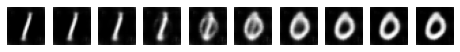

In [ ]:
zero_image = mnist_test.data[mnist_test.targets==0].data.view(-1,1,28,28).cuda()
zero_image = zero_image/255.0
one_image = mnist_test.data[mnist_test.targets==1].data.view(-1,1,28,28).cuda()
one_image = one_image/255.0

zero_z_mu, zero_z_var = vae_net.encoder(zero_image)
one_z_mu, one_z_var = vae_net.encoder(one_image)

z = torch.empty(10,z_dim).cuda()
alpha = torch.linspace(0,1,10)
for i in range(10):
    z[i] = alpha[i]*zero_z_mu[0] + (1-alpha[i])*one_z_mu[0]

# make sample with z
sample = vae_net.decoder(z).cuda()
imgs = sample.view(-1,28,28)
imgs = imgs.detach().cpu()

fig, axes = plt.subplots(1,10,figsize=(8,8))
ax = axes.ravel()
for i in range(10):
    img = imgs[i]
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
plt.show()